### Climate skill at 1&deg;: ENSO correlation coefficients

In [1]:
from collections import namedtuple

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs

from utils import get_beaker_dataset_variables, get_scalar_metrics
from constants import INFERENCE_COMPARISON_1DEG, SECONDS_PER_DAY, WANDB_ENTITY, WANDB_PROJECT

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [3]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

EVAL_VARS = [
    EvalVar("ULWRFtoa", "outgoing longwave radiation", "W/m^2", None),
    EvalVar("PRATEsfc", "surface precipitation", "mm", SECONDS_PER_DAY),
]
DS_VARS = [var.name for var in EVAL_VARS]
SCALAR_METRIC_NAMES = [f'inference/enso_coefficient/rmse/{varname}' for varname in DS_VARS]

In [4]:
datasets = []
metrics = []
wandb_api = wandb.Api()
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        for ic_name, ic_run in group_runs.items():
            if "-" in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([duration_name, group_name, ic_name])
            print(f"Getting dataset for run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'enso_coefficient_diagnostics.nc', DS_VARS)
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    ic_dataset[var.name] = var.conversion_factor * ic_dataset[var.name]
            datasets.append(
                ic_dataset
                .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
            )
            print(f"Getting scalar metrics for run: {full_key=}")
            wandb_run = wandb_api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{ic_run}")
            run_metrics = get_scalar_metrics(wandb_run, SCALAR_METRIC_NAMES)
            metrics.append(
                xr.Dataset(run_metrics)
                .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
            )
enso_coefficient_maps = xr.merge(datasets).squeeze()
enso_coefficient_metrics = xr.merge(metrics)

Downloading ⠴ 0:00:01 62.0 MB/s 26.7 MB

Getting scalar metrics for run: full_key='81yr/ACE-climSST/IC2'


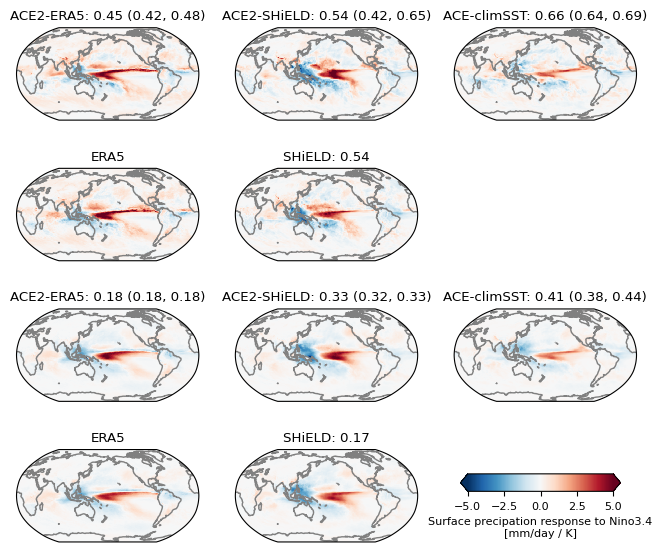

In [5]:
plot_var = 'PRATEsfc'
cbar_label = 'Surface precipation response to Nino3.4\n[mm/day / K]'
var_scale = 5
plot_kwargs = dict(vmin=-var_scale, vmax=var_scale, cmap='RdBu_r')
metric_var = f'inference/enso_coefficient/rmse/{plot_var}'
metric_da = (SECONDS_PER_DAY * enso_coefficient_metrics[metric_var])
fmt = '0.2g'

fig, axes = plt.subplots(
    2 * enso_coefficient_maps.sizes['duration'],
    3, 
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180))
)
for i_duration, duration in enumerate(enso_coefficient_maps.duration):
    duration_axes = axes[(2 * i_duration):(2 * i_duration + 2), :]
    ax0 = duration_axes[0, 0]
    h = enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE2-ERA5'
    ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax0_rmse = metric_da.sel(duration=duration, group='ACE2-ERA5')
    ax0.set_title(f'ACE2-ERA5: {ax0_rmse.mean().item():{fmt}} ({ax0_rmse.min().item():{fmt}}, {ax0_rmse.max().item():{fmt}})')
    ax1 = duration_axes[0, 1]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE2-SHiELD'
    ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax1_rmse = metric_da.sel(duration=duration, group='ACE2-SHiELD')
    ax1.set_title(f'ACE2-SHiELD: {ax1_rmse.mean().item():{fmt}} ({ax1_rmse.min().item():{fmt}}, {ax1_rmse.max().item():{fmt}})')
    ax2 = duration_axes[0, 2]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE-climSST'
    ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax2_rmse = metric_da.sel(duration=duration, group='ACE-climSST')
    ax2.set_title(f'ACE-climSST: {ax2_rmse.mean().item():{fmt}} ({ax2_rmse.min().item():{fmt}}, {ax2_rmse.max().item():{fmt}})')
    ax3 = duration_axes[1, 0]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='target', group='ACE2-ERA5'
    ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax3.set_title('ERA5')
    ax4 = duration_axes[1, 1]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='target', group='ACE2-SHiELD'
    ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax4_rmse = metric_da.sel(duration=duration, IC='IC0', group='SHiELD-reference')
    ax4.set_title(f'SHiELD: {ax4_rmse.item():{fmt}}')
    [ax.coastlines(color='gray') for ax in duration_axes.flatten()[:-1]]
    ax5 = duration_axes[1, 2]
    ax5.set_axis_off()
    del ax5
    if i_duration == enso_coefficient_maps.sizes['duration'] - 1:
        ax5 = fig.add_axes([0.68, 0.20, 0.2, 0.025])
        fig.colorbar(
            h, cax=ax5,
            orientation='horizontal',
            extend='both',
            ticks=np.linspace(-var_scale, var_scale, 5),
            label=cbar_label
        )
fig.set_size_inches([8, 7])
fig.savefig(f'enso_coefficient_maps_{plot_var}.png', bbox_inches='tight', facecolor='w')

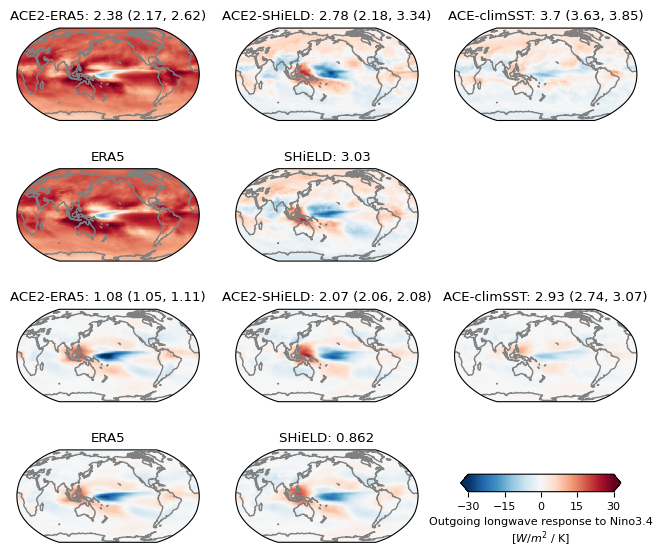

In [6]:
plot_var = 'ULWRFtoa'
cbar_label = 'Outgoing longwave response to Nino3.4\n' + r'[$W/{m^{2}}$ / K]'
var_scale = 30
plot_kwargs = dict(vmin=-var_scale, vmax=var_scale, cmap='RdBu_r')
metric_var = f'inference/enso_coefficient/rmse/{plot_var}'
metric_da = enso_coefficient_metrics[metric_var]
fmt = '0.3g'

fig, axes = plt.subplots(
    2 * enso_coefficient_maps.sizes['duration'],
    3, 
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180))
)
for i_duration, duration in enumerate(enso_coefficient_maps.duration):
    duration_axes = axes[(2 * i_duration):(2 * i_duration + 2), :]
    ax0 = duration_axes[0, 0]
    h = enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE2-ERA5'
    ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax0_rmse = metric_da.sel(duration=duration, group='ACE2-ERA5')
    ax0.set_title(f'ACE2-ERA5: {ax0_rmse.mean().item():{fmt}} ({ax0_rmse.min().item():{fmt}}, {ax0_rmse.max().item():{fmt}})')
    ax1 = duration_axes[0, 1]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE2-SHiELD'
    ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax1_rmse = metric_da.sel(duration=duration, group='ACE2-SHiELD')
    ax1.set_title(f'ACE2-SHiELD: {ax1_rmse.mean().item():{fmt}} ({ax1_rmse.min().item():{fmt}}, {ax1_rmse.max().item():{fmt}})')
    ax2 = duration_axes[0, 2]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='prediction', group='ACE-climSST'
    ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax2_rmse = metric_da.sel(duration=duration, group='ACE-climSST')
    ax2.set_title(f'ACE-climSST: {ax2_rmse.mean().item():{fmt}} ({ax2_rmse.min().item():{fmt}}, {ax2_rmse.max().item():{fmt}})')
    ax3 = duration_axes[1, 0]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='target', group='ACE2-ERA5'
    ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax3.set_title('ERA5')
    ax4 = duration_axes[1, 1]
    enso_coefficient_maps[plot_var].sel(
        IC='IC0', duration=duration, source='target', group='ACE2-SHiELD'
    ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
    ax4_rmse = metric_da.sel(duration=duration, IC='IC0', group='SHiELD-reference')
    ax4.set_title(f'SHiELD: {ax4_rmse.item():{fmt}}')
    [ax.coastlines(color='gray') for ax in duration_axes.flatten()[:-1]]
    ax5 = duration_axes[1, 2]
    ax5.set_axis_off()
    del ax5
    if i_duration == enso_coefficient_maps.sizes['duration'] - 1:
        ax5 = fig.add_axes([0.68, 0.20, 0.2, 0.025])
        fig.colorbar(
            h, cax=ax5,
            orientation='horizontal',
            extend='both',
            ticks=np.linspace(-var_scale, var_scale, 5),
            label=cbar_label
        )
fig.set_size_inches([8, 7])
fig.savefig(f'enso_coefficient_maps_{plot_var}.png', bbox_inches='tight', facecolor='w')